### Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import math

In [3]:
import pandas as pd
import numpy as np

In [4]:
from collections import defaultdict

In [5]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

In [6]:
pd.__version__

'0.23.4'

In [7]:
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit

In [8]:
import sys
sys.path.append('../src')

In [9]:
from workflow.data_utils import load_csv

In [10]:
from workflow.log_utils import get_logger

In [11]:
# from workflow.structured import add_datepart, train_cats, proc_df, apply_cats

In [12]:
from fastai.structured import add_datepart, train_cats, proc_df, apply_cats

### Constants

In [13]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [14]:
def half_bool_columns_to_float_type(df):
    for col in df.columns:
        if is_string_dtype(df[col]):
            unqs = df[col].unique()
            if len(unqs) == 2 and (False in unqs or True in unqs):
                print(col)
                df[col] = df[col].astype(float)

In [15]:
def check_columns_and_types_same_in(a,b):
    same_names = all(a.columns == b.columns)
    same_types = [a[col].dtype == b[col].dtype for col in a.columns]
    return same_names, all(same_types)

In [16]:
# some duplicated info
drop_columns = ['date', 'sessionId', 'visitId']
LN_SPLITTER ='\n====\n'

### Loads 

In [19]:
%%time
full_train = load_csv('../data/processed_data/processed_train.csv',
                      low_memory=False, nrows=None)

CPU times: user 5.01 s, sys: 913 ms, total: 5.92 s
Wall time: 7.03 s


In [20]:
full_train.drop(columns=drop_columns, inplace=True)

In [21]:
half_bool_columns_to_float_type(full_train)

trafficSource_adwordsClickInfo.isVideoAd
trafficSource_isTrueDirect


In [22]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 32 columns):
channelGrouping                                 903653 non-null object
fullVisitorId                                   903653 non-null object
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device_browser                                  903653 non-null object
device_deviceCategory                           903653 non-null object
device_isMobile                                 903653 non-null bool
device_operatingSystem                          903653 non-null object
geoNetwork_city                                 903653 non-null object
geoNetwork_continent                            903653 non-null object
geoNetwork_country                              903653 non-null object
geoNetwork_metro                                903653 non-null object
geoNetwork_networkDomain                 

In [23]:
display_all(full_train.head())

,channelGrouping,fullVisitorId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,totals_transactionRevenue
0,Organic Search,1131660440785968503,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN
1,Organic Search,377306020877927890,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN
2,Organic Search,3895546263509774583,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN
3,Organic Search,4763447161404445595,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google,NaN
4,Organic Search,27294437909732085,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google,NaN


In [24]:
%%time
test_df = load_csv('../data/processed_data/processed_test.csv', low_memory=False, nrows=None)

CPU times: user 4.75 s, sys: 745 ms, total: 5.5 s
Wall time: 6.48 s


In [25]:
test_df.drop(columns=drop_columns, inplace=True)

In [26]:
half_bool_columns_to_float_type(test_df)

trafficSource_adwordsClickInfo.isVideoAd
trafficSource_isTrueDirect


In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804684 entries, 0 to 804683
Data columns (total 31 columns):
channelGrouping                                 804684 non-null object
fullVisitorId                                   804684 non-null object
visitNumber                                     804684 non-null int64
visitStartTime                                  804684 non-null int64
device_browser                                  804684 non-null object
device_deviceCategory                           804684 non-null object
device_isMobile                                 804684 non-null bool
device_operatingSystem                          804684 non-null object
geoNetwork_city                                 804684 non-null object
geoNetwork_continent                            804684 non-null object
geoNetwork_country                              804684 non-null object
geoNetwork_metro                                804684 non-null object
geoNetwork_networkDomain                 

#### Check column names and types are == for train and test

In [27]:
check_columns_and_types_same_in(full_train.drop('totals_transactionRevenue', axis=1), test_df)

(True, True)

In [23]:
display_all(full_train.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
channelGrouping,903653,8,Organic Search,381561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fullVisitorId,903653,714167,1957458976293878100,278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visitNumber,903653,NaN,NaN,NaN,2.2649,9.28373,1,1,1,1,395
visitStartTime,903653,NaN,NaN,NaN,1.48501e+09,9.02212e+06,1.47003e+09,1.47756e+09,1.48395e+09,1.49276e+09,1.50166e+09
device_browser,903653,54,Chrome,620364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_deviceCategory,903653,3,desktop,664479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_isMobile,903653,2,False,664530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_operatingSystem,903653,20,Windows,350072,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geoNetwork_city,903653,649,not available in demo dataset,508229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geoNetwork_continent,903653,6,Americas,450377,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Workflow

In [28]:
full_train['totals_transactionRevenue'] = full_train['totals_transactionRevenue'].fillna(value=0)

In [29]:
# posix seconds to datetime
full_train['visitStartTime'] = pd.to_datetime(full_train.visitStartTime, unit='s')

In [30]:
test_df['visitStartTime'] = pd.to_datetime(test_df.visitStartTime, unit='s')

#### Take fullVisitorId -> validation ids, if it has transaction after 2017-04-30 

In [28]:
validationIds = full_train[full_train.visitStartTime > '2017-04-30'].fullVisitorId.unique()

In [29]:
validationIds.shape

(161118,)

In [30]:
# save for later use
np.save('../data/tmp/validIds.npy',validationIds)

#### Continue workflow: make time feature columns

In [31]:
# make time features
add_datepart(full_train, 'visitStartTime', time=True, drop=False)

In [32]:
# make time features
add_datepart(test_df, 'visitStartTime', time=True, drop=False)

In [33]:
set(full_train.drop('totals_transactionRevenue', axis=1).columns) - set(test_df.columns)

set()

#### Drop fullVisitorId columns to not categorize them

In [34]:
train_visitorIds = full_train.fullVisitorId
test_visitorIds = test_df.fullVisitorId

In [35]:
full_train.drop(columns=['fullVisitorId'], inplace=True)
test_df.drop(columns=['fullVisitorId'], inplace=True)

In [36]:
# make categorical data
train_cats(full_train)

In [37]:
apply_cats(test_df, full_train)

In [43]:
display_all(full_train.isnull().sum().sort_index()/len(full_train))

channelGrouping                                 0.000000
device_browser                                  0.000000
device_deviceCategory                           0.000000
device_isMobile                                 0.000000
device_operatingSystem                          0.000000
geoNetwork_city                                 0.000000
geoNetwork_continent                            0.000000
geoNetwork_country                              0.000000
geoNetwork_metro                                0.000000
geoNetwork_networkDomain                        0.000000
geoNetwork_region                               0.000000
geoNetwork_subContinent                         0.000000
totals_bounces                                  0.501324
totals_hits                                     0.000000
totals_newVisits                                0.221980
totals_pageviews                                0.000111
totals_transactionRevenue                       0.000000
trafficSource_adContent        

In [44]:
display_all(test_df.isnull().sum().sort_index()/len(test_df))

channelGrouping                                 0.000000
device_browser                                  0.019764
device_deviceCategory                           0.000000
device_isMobile                                 0.000000
device_operatingSystem                          0.001150
geoNetwork_city                                 0.009569
geoNetwork_continent                            0.000000
geoNetwork_country                              0.000034
geoNetwork_metro                                0.001099
geoNetwork_networkDomain                        0.031993
geoNetwork_region                               0.007047
geoNetwork_subContinent                         0.000000
totals_bounces                                  0.476878
totals_hits                                     0.000000
totals_newVisits                                0.248935
totals_pageviews                                0.000173
trafficSource_adContent                         0.994974
trafficSource_adwordsClickInfo.

In [38]:
# add back fullVisitosIds
full_train['fullVisitorId'] = train_visitorIds
test_df['fullVisitorId'] = test_visitorIds

In [39]:
# sort train dataframe by time
full_train.sort_values(by='visitStartTime', inplace=True)

In [40]:
full_train.reset_index(drop=True, inplace=True)

In [41]:
full_train.head()

,channelGrouping,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,...,visitStartTimeIs_month_start,visitStartTimeIs_quarter_end,visitStartTimeIs_quarter_start,visitStartTimeIs_year_end,visitStartTimeIs_year_start,visitStartTimeHour,visitStartTimeMinute,visitStartTimeSecond,visitStartTimeElapsed,fullVisitorId
0,Direct,3,2016-08-01 07:00:12,Safari,mobile,True,iOS,not available in demo dataset,Americas,United States,...,True,False,False,False,False,7,0,12,1470034812,0423043652415339154
1,Social,1,2016-08-01 07:04:26,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Thailand,...,True,False,False,False,False,7,4,26,1470035066,8294721032567046680
2,Organic Search,1,2016-08-01 07:04:41,Amazon Silk,tablet,True,Android,not available in demo dataset,Americas,United States,...,True,False,False,False,False,7,4,41,1470035081,7718623669497357235
3,Organic Search,1,2016-08-01 07:06:01,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Canada,...,True,False,False,False,False,7,6,1,1470035161,4798058133221713505
4,Direct,1,2016-08-01 07:06:10,Chrome,desktop,False,Windows,Quezon City,Asia,Philippines,...,True,False,False,False,False,7,6,10,1470035170,5076747981380011349


In [42]:
check_columns_and_types_same_in(full_train.drop(columns=['totals_transactionRevenue']), test_df)

(True, True)

In [43]:
%%time
os.makedirs('../data/tmp', exist_ok=True)
full_train.to_feather('../data/tmp/raw_train')

CPU times: user 204 ms, sys: 121 ms, total: 325 ms
Wall time: 2.71 s


In [44]:
%%time
os.makedirs('../data/tmp', exist_ok=True)
test_df.to_feather('../data/tmp/raw_test')

CPU times: user 187 ms, sys: 96.8 ms, total: 284 ms
Wall time: 1.94 s


#### Preprocess

In [25]:
%time full_train = pd.read_feather('../data/tmp/raw_train', nthreads=-1)

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 259 ms, sys: 162 ms, total: 421 ms
Wall time: 3.24 s


In [295]:
%time test_df = pd.read_feather('../data/tmp/raw_test', nthreads=-1)

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 237 ms, sys: 126 ms, total: 363 ms
Wall time: 2.41 s


#####  TimeSeries Split way to make Validation dataset

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

In [27]:
logger = get_logger('new')

In [53]:
# sanity check
for i, (tr_index, val_index) in enumerate(tscv.split(full_train.visitStartTime)):
    logger.debug(f'Working with fold {i}\n===========\n')
    print(f'Train max time: {full_train.iloc[tr_index].visitStartTime.max()}, Valid max time: {full_train.iloc[val_index].visitStartTime.min()}')
    print(f'train_set length: {len(tr_index)}, valid_set length: {len(val_index)}')

2018-10-05 13:16:48,720 - new - DEBUG - Working with fold 0

Train max time: 2016-10-03 21:24:49, Valid max time: 2016-10-03 21:25:22
train_set length: 150613, valid_set length: 150608
2018-10-05 13:16:48,768 - new - DEBUG - Working with fold 1

Train max time: 2016-11-16 16:56:29, Valid max time: 2016-11-16 16:56:35
train_set length: 301221, valid_set length: 150608
2018-10-05 13:16:48,840 - new - DEBUG - Working with fold 2

Train max time: 2017-01-09 08:03:25, Valid max time: 2017-01-09 08:03:30
train_set length: 451829, valid_set length: 150608
2018-10-05 13:16:48,937 - new - DEBUG - Working with fold 3

Train max time: 2017-03-19 05:10:52, Valid max time: 2017-03-19 05:13:08
train_set length: 602437, valid_set length: 150608
2018-10-05 13:16:49,060 - new - DEBUG - Working with fold 4

Train max time: 2017-05-25 16:53:03, Valid max time: 2017-05-25 16:53:20
train_set length: 753045, valid_set length: 150608


##### Working on validation pipeline for feature selection

In [35]:
trn_sample_sz = 100000
# trn_sample_sz = len(full_train)

tst_sample_sz = 100000
# tst_sample_sz = len(test_df)

N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

In [36]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

In [37]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)
    return res

In [38]:
train_smpl_data = full_train.iloc[:trn_sample_sz].copy()
# test_smpl_data = test_df.iloc[:tst_sample_sz].copy()

In [39]:
stats_cols = ['col_name'] + [f'val_rmse_{i}' for i in range(N_SPLITS)] +\
             [f'val_rsq_{i}' for i in range(N_SPLITS)] +\
             ['val_mean_rmse', 'val_mean_rsq', 'val_var_rmse', 'val_var_rsq']

stats_dict = {name:[] for name in stats_cols}

In [40]:
all_features = train_smpl_data.drop(columns=[
    'visitStartTime', 'fullVisitorId', 'totals_transactionRevenue']).columns
columns_to_use = ['visitStartTime', 'fullVisitorId', 'totals_transactionRevenue']

In [41]:
%%time
for feature_name in all_features:
    logger.debug(f'Adding feature name: {feature_name}{LN_SPLITTER}')
    # append feature name
    columns_to_use.append(feature_name)
    
    # create sample to train and validate model on
    full_train_smpl = train_smpl_data[columns_to_use].copy()
    
    # test_preds = np.zeros(len(test_smpl))

    # create array to collect metrics for every new data sample
    metrics = np.zeros((N_SPLITS, 4))

    stats_dict['col_name'].append(feature_name)

    for i, (tr_index, val_index) in enumerate(tscv.split(full_train_smpl.visitStartTime)):

        logger.debug(f'Process train split on fold {i}{LN_SPLITTER}')
        X_train, y_train, nas = proc_df(full_train_smpl.iloc[tr_index], 'totals_transactionRevenue',
                                        skip_flds=['fullVisitorId', 'visitStartTime'], max_n_cat=None)

        logger.debug(f'Process valid split on fold {i}{LN_SPLITTER}')
        X_valid, y_valid, _ = proc_df(full_train_smpl.iloc[val_index], 'totals_transactionRevenue',
                                      skip_flds=['fullVisitorId', 'visitStartTime'],
                                      max_n_cat=None, na_dict=nas)
        if i == 0:
            logger.debug(f'Number of featues: {len(X_train.columns)}{LN_SPLITTER}')
    #     if i == 0:
    #         logger.debug(f'Process test_set on fold {i}{LN_SPLITTER}')
    #         X_test, _, _ = proc_df(test_smpl, skip_flds=['fullVisitorId', 'visitStartTime'],
    #                                max_n_cat=100, na_dict=nas)

        print('Sanity check for column names and types for train and valid')
        print(f'{check_columns_and_types_same_in(X_train, X_valid)}')

    #     print('Sanity check for column names and types for train and test')
    #     print(f'{check_columns_and_types_same_in(X_train, X_test)}')

        # log(y) for training the model IMPORTANT!!!
        y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)
        
        # train model
        m = RandomForestRegressor(n_jobs=-1, n_estimators=30)
        m.fit(X_train, y_train)

        logger.debug(f'Printing score for fold {i}{LN_SPLITTER}')
        result = print_score(m)
        metrics[i] = result

        stats_dict[f'val_rmse_{i}'].append(result[1])
        stats_dict[f'val_rsq_{i}'].append(result[3])

    #     logger.debug(f'Predicting test on iteration: {i}{LN_SPLITTER}')
    #     y_hat = m.predict(X_test)
    #     y_hat[y_hat < 0] = 0 
    #     test_preds += y_hat / N_SPLITS

    stats_dict['val_mean_rmse'].append(metrics[:,1].mean())
    stats_dict['val_mean_rsq'].append(metrics[:,3].mean())
    stats_dict['val_var_rmse'].append(metrics[:,1].var())
    stats_dict['val_var_rsq'].append(metrics[:,3].var())
    


2018-10-06 18:50:49,232 - new - DEBUG - Adding feature name: channelGrouping
====

2018-10-06 18:50:49,241 - new - DEBUG - Process train split on fold 0
====

2018-10-06 18:50:49,251 - new - DEBUG - Process valid split on fold 0
====

2018-10-06 18:50:49,260 - new - DEBUG - Number of featues: 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:50:49,386 - new - DEBUG - Printing score for fold 0
====

[1.6206237111234083, 2.28363921144948, 0.009663614548565458, 0.014215467890061229]
2018-10-06 18:50:49,808 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:50:49,819 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:50:49,952 - new - DEBUG - Printing score for fold 1
====

[1.974638065732493, 2.3390946716735543, 0.019432283018605556, 0.026174595143956814]
2018-10-06 18:50:50,383 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18

2018-10-06 18:51:01,447 - new - DEBUG - Process train split on fold 0
====

2018-10-06 18:51:01,461 - new - DEBUG - Process valid split on fold 0
====

2018-10-06 18:51:01,474 - new - DEBUG - Number of featues: 5
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:51:01,608 - new - DEBUG - Printing score for fold 0
====

[1.5804115481832568, 2.2928208092122766, 0.05819986798624877, 0.0062726436599565005]
2018-10-06 18:51:02,047 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:51:02,065 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:51:02,215 - new - DEBUG - Printing score for fold 1
====

[1.9352157502515936, 2.3478227904003135, 0.058194198522417806, 0.0188935545632396]
2018-10-06 18:51:02,661 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18:51:02,681 - new - DEBUG - Process valid split on fold 2
====

Sanity check for co

2018-10-06 18:51:16,737 - new - DEBUG - Process train split on fold 0
====

2018-10-06 18:51:16,762 - new - DEBUG - Process valid split on fold 0
====

2018-10-06 18:51:16,785 - new - DEBUG - Number of featues: 9
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:51:16,921 - new - DEBUG - Printing score for fold 0
====

[1.3064867339487531, 2.3721766157180335, 0.3563817255966376, -0.06370464874694282]
2018-10-06 18:51:17,373 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:51:17,396 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:51:17,660 - new - DEBUG - Printing score for fold 1
====

[1.6866009929621841, 2.4496917828570792, 0.2846356642801956, -0.06809133455929661]
2018-10-06 18:51:18,124 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18:51:18,154 - new - DEBUG - Process valid split on fold 2
====

Sanity check for colu

2018-10-06 18:51:36,685 - new - DEBUG - Process train split on fold 0
====

2018-10-06 18:51:36,715 - new - DEBUG - Process valid split on fold 0
====

2018-10-06 18:51:36,746 - new - DEBUG - Number of featues: 13
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:51:36,992 - new - DEBUG - Printing score for fold 0
====

[1.133820276187477, 2.380119758824752, 0.5152623014299371, -0.07084012427148889]
2018-10-06 18:51:37,462 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:51:37,491 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:51:37,869 - new - DEBUG - Printing score for fold 1
====

[1.5008628275351814, 2.477388053855879, 0.43351999637000316, -0.09237959439282052]
2018-10-06 18:51:38,351 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18:51:38,388 - new - DEBUG - Process valid split on fold 2
====

Sanity check for colum

2018-10-06 18:51:57,426 - new - DEBUG - Process valid split on fold 0
====

2018-10-06 18:51:57,456 - new - DEBUG - Number of featues: 20
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:51:57,600 - new - DEBUG - Printing score for fold 0
====

[0.618983976147438, 2.0998993463527706, 0.8555301669332802, 0.16646474545611545]
2018-10-06 18:51:58,078 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:51:58,117 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:51:58,407 - new - DEBUG - Printing score for fold 1
====

[0.7360675136344637, 2.106391219305514, 0.8637495697122414, 0.21029739210576792]
2018-10-06 18:51:58,916 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18:51:58,960 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:51:59,472 - n

2018-10-06 18:52:19,492 - new - DEBUG - Process valid split on fold 0
====

2018-10-06 18:52:19,529 - new - DEBUG - Number of featues: 25
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:52:19,679 - new - DEBUG - Printing score for fold 0
====

[0.613014629734594, 2.1149637161424217, 0.8583032019714716, 0.15446252903479918]
2018-10-06 18:52:20,164 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:52:20,210 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:52:20,513 - new - DEBUG - Printing score for fold 1
====

[0.7367208949694436, 2.092433595513689, 0.8635075728902151, 0.2207283632587187]
2018-10-06 18:52:21,040 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18:52:21,092 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:52:21,623 - ne

2018-10-06 18:52:45,591 - new - DEBUG - Process valid split on fold 0
====

2018-10-06 18:52:45,644 - new - DEBUG - Number of featues: 31
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:52:45,912 - new - DEBUG - Printing score for fold 0
====

[0.6157426794708317, 2.110324955702041, 0.85703923200061, 0.1581675045865667]
2018-10-06 18:52:46,417 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:52:46,476 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:52:46,918 - new - DEBUG - Printing score for fold 1
====

[0.7345740656744373, 2.1117515886450122, 0.8643019008355034, 0.20627298882648903]
2018-10-06 18:52:47,472 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18:52:47,541 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:52:48,308 - new

2018-10-06 18:53:14,499 - new - DEBUG - Number of featues: 35
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:53:14,765 - new - DEBUG - Printing score for fold 0
====

[0.6003231140406463, 2.093859261026599, 0.8641096902920553, 0.17125295909152716]
2018-10-06 18:53:15,288 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:53:15,365 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:53:15,942 - new - DEBUG - Printing score for fold 1
====

[0.7313905326365391, 2.113146290400947, 0.8654755422475295, 0.20522421204406963]
2018-10-06 18:53:16,522 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18:53:16,603 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:53:17,381 - new - DEBUG - Printing score for fold 2
====

[0.7734734745896752, 2.02556639

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:53:44,712 - new - DEBUG - Printing score for fold 0
====

[0.6103790897633873, 2.1406279689356147, 0.8595189797798983, 0.13381749550833766]
2018-10-06 18:53:45,252 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:53:45,337 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:53:46,024 - new - DEBUG - Printing score for fold 1
====

[0.6949455315188483, 2.192415069844578, 0.8785481554865953, 0.14447824435072532]
2018-10-06 18:53:46,626 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18:53:46,713 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:53:47,416 - new - DEBUG - Printing score for fold 2
====

[0.7512997612084013, 2.0968119471784314, 0.8752786514067259, 0.25427687603947124]
2018-10-06 18:53

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:54:18,354 - new - DEBUG - Printing score for fold 0
====

[0.590003704127268, 2.1185623993288565, 0.8687413798261417, 0.1515826590970868]
2018-10-06 18:54:18,892 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:54:18,972 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:54:19,543 - new - DEBUG - Printing score for fold 1
====

[0.6980982458434446, 2.123675195512734, 0.8774436904657374, 0.19728442455741058]
2018-10-06 18:54:20,148 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18:54:20,238 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:54:21,047 - new - DEBUG - Printing score for fold 2
====

[0.7363290853175016, 2.1294384562317723, 0.8801996166300771, 0.2308893395281254]
2018-10-06 18:54:21

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:54:51,653 - new - DEBUG - Printing score for fold 0
====

[0.5759998625672113, 2.1171178827604873, 0.8748983269729561, 0.1527392312064374]
2018-10-06 18:54:52,207 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:54:52,286 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:54:52,860 - new - DEBUG - Printing score for fold 1
====

[0.6926067891547087, 2.14968033766857, 0.8793642384884582, 0.17750499512391804]
2018-10-06 18:54:53,475 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18:54:53,569 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:54:54,389 - new - DEBUG - Printing score for fold 2
====

[0.7290531584437233, 2.1379843549760182, 0.8825554987004528, 0.22470373625035897]
2018-10-06 18:54:5

2018-10-06 18:55:27,966 - new - DEBUG - Printing score for fold 0
====

[0.5937167084760202, 2.5161313486117427, 0.8670841110319258, -0.19672298856146386]
2018-10-06 18:55:28,525 - new - DEBUG - Process train split on fold 1
====

2018-10-06 18:55:28,618 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:55:29,312 - new - DEBUG - Printing score for fold 1
====

[0.7151020953191666, 2.192937948542517, 0.8714006769336652, 0.14407012140800035]
2018-10-06 18:55:29,990 - new - DEBUG - Process train split on fold 2
====

2018-10-06 18:55:30,103 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-06 18:55:31,359 - new - DEBUG - Printing score for fold 2
====

[0.7370240779650804, 2.1249217023932805, 0.8799733599727891, 0.23414860188342568]
2018-10-06 18:55:32,099 - new - DEBUG - Process train split on fold 3
====

2018-10-06 1

In [42]:
stats_df = pd.DataFrame(stats_dict)
os.makedirs('../log', exist_ok=True)
stats_df.to_feather('../log/cat_encoded_features_log')

In [17]:
stats_df = pd.read_feather('../log/ohe_features_log')

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


#####  Evaluating stats for feature selection

In [43]:
stats_df.col_name.tolist()

['channelGrouping',
 'visitNumber',
 'device_browser',
 'device_deviceCategory',
 'device_isMobile',
 'device_operatingSystem',
 'geoNetwork_city',
 'geoNetwork_continent',
 'geoNetwork_country',
 'geoNetwork_metro',
 'geoNetwork_networkDomain',
 'geoNetwork_region',
 'geoNetwork_subContinent',
 'totals_bounces',
 'totals_hits',
 'totals_newVisits',
 'totals_pageviews',
 'trafficSource_adContent',
 'trafficSource_adwordsClickInfo.adNetworkType',
 'trafficSource_adwordsClickInfo.gclId',
 'trafficSource_adwordsClickInfo.isVideoAd',
 'trafficSource_adwordsClickInfo.page',
 'trafficSource_adwordsClickInfo.slot',
 'trafficSource_campaign',
 'trafficSource_isTrueDirect',
 'trafficSource_keyword',
 'trafficSource_medium',
 'trafficSource_referralPath',
 'trafficSource_source',
 'visitStartTimeYear',
 'visitStartTimeMonth',
 'visitStartTimeWeek',
 'visitStartTimeDay',
 'visitStartTimeDayofweek',
 'visitStartTimeDayofyear',
 'visitStartTimeIs_month_end',
 'visitStartTimeIs_month_start',
 'visit

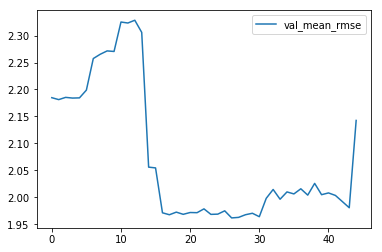

In [52]:
stats_df.plot( y='val_mean_rmse')

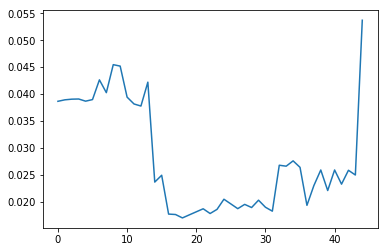

In [53]:
stats_df.val_var_rmse.plot()

##### First simple way to make validation 

In [56]:
# valid_index = full_train[full_train.fullVisitorId.isin(validationIds)].index

In [57]:
# train_index = full_train[~full_train.fullVisitorId.isin(validationIds)].index

In [58]:
# def split_vals_array(a, train_index, val_index):
#     return a[train_index].copy(), a[val_index].copy()

# def split_vals_df(a, train_index, val_index):
#     return a.iloc[train_index].copy(), a.iloc[val_index].copy()


# raw_train, raw_valid = split_vals_df(full_train, train_index, valid_index)
# X_train, X_valid = split_vals_df(df, train_index, valid_index)
# y_train, y_valid = split_vals_array(y, train_index, valid_index)

# X_train.shape, y_train.shape, X_valid.shape

((681849, 321), (681849,), (221804, 321))

In [59]:
# y_train.mean(), y_valid.mean()

(0.20146147902692166, 0.3059895624328279)

In [60]:
# y_train.max(), y_valid.max()

(23.497337833653027, 23.86437469605166)

#### CV and test

In [296]:
trn_sample_sz = 100000
trn_sample_sz = len(full_train)

tst_sample_sz = 100000
tst_sample_sz = len(test_df)

N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

In [297]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

In [298]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)
    return res

In [316]:
stats_cols = ['experiment'] + [f'val_rmse_{i}' for i in range(N_SPLITS)] +\
             [f'val_rsq_{i}' for i in range(N_SPLITS)] +\
             ['val_mean_rmse', 'val_mean_rsq', 'val_var_rmse', 'val_var_rsq', 'submission_fname']

stats_dict = {name:[] for name in stats_cols}

In [317]:
# TODO: add column names you want to use for experiment here
# columns_to_use = ['visitStartTime', 'fullVisitorId', 'totals_transactionRevenue']

In [318]:
full_train_smpl = full_train.iloc[:trn_sample_sz].copy()
test_smpl = test_df.iloc[:tst_sample_sz].copy()

In [319]:
rf_params = {'n_estimators': 1000,
             'min_samples_leaf': 25,
             'max_features': 0.5}

In [320]:
# This pipeline is for testing selected features on test set

stats_dict['experiment'].append(f"RF, params: {rf_params}, smpl: {trn_sample_sz}")

# TODO!!! should change fname according to experiment
submission_fname = "rf_tuned.csv"
stats_dict['submission_fname'].append(submission_fname)

In [322]:
def train_valid_test(model_params, is_test=False):
    """
    Base function for validation and test
    purposes. Should be updated to be more
    flexible.
    TODO: add param dict for model
    """

    if is_test:
        test_preds = np.zeros(len(test_smpl))

    # create array to collect metrics for every new data sample
    metrics = np.zeros((N_SPLITS, 4))

    for i, (tr_index, val_index) in enumerate(tscv.split(full_train_smpl.visitStartTime)):

        logger.debug(f'Process train split on fold {i}{LN_SPLITTER}')
        X_train, y_train, nas = proc_df(full_train_smpl.iloc[tr_index], 'totals_transactionRevenue',
                                        skip_flds=['fullVisitorId', 'visitStartTime'], max_n_cat=None)

        logger.debug(f'Process valid split on fold {i}{LN_SPLITTER}')
        X_valid, y_valid, _ = proc_df(full_train_smpl.iloc[val_index], 'totals_transactionRevenue',
                                      skip_flds=['fullVisitorId',
                                                 'visitStartTime'],
                                      max_n_cat=None, na_dict=nas)
        if is_test:
            if i == 0:
                logger.debug(f'Process test_set on fold {i}{LN_SPLITTER}')
                X_test, _, _ = proc_df(test_smpl, skip_flds=['fullVisitorId', 'visitStartTime'],
                                       max_n_cat=None, na_dict=nas)

                print('Sanity check for column names and types for train and test')
                print(f'{check_columns_and_types_same_in(X_train, X_test)}')

        if i == 0:
            logger.debug(f'Number of features used: {len(X_train.columns)}')
            print('Sanity check for column names and types for train and valid')
            print(f'{check_columns_and_types_same_in(X_train, X_valid)}')

        # log(y) for training the model IMPORTANT!!!
        y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)

        # train model
        m = RandomForestRegressor(**model_params, n_jobs=-1)
        if i == 0:
            print(m)
        m.fit(X_train, y_train)

        logger.debug(f'Printing score for fold {i}{LN_SPLITTER}')
        result = print_score(m)
        metrics[i] = result

        stats_dict[f'val_rmse_{i}'].append(result[1])
        stats_dict[f'val_rsq_{i}'].append(result[3])

        if is_test:
            logger.debug(f'Predicting test on iteration: {i}{LN_SPLITTER}')
            y_hat = m.predict(X_test)
            y_hat[y_hat < 0] = 0
            test_preds += y_hat / N_SPLITS

    stats_dict['val_mean_rmse'].append(metrics[:, 1].mean())
    stats_dict['val_mean_rsq'].append(metrics[:, 3].mean())
    stats_dict['val_var_rmse'].append(metrics[:, 1].var())
    stats_dict['val_var_rsq'].append(metrics[:, 3].var())
    
    
    if is_test:
        return test_preds

In [323]:
test_preds = train_valid_test(rf_params, is_test=True)

2018-10-06 23:24:31,066 - new - DEBUG - Process train split on fold 0
====

2018-10-06 23:24:31,356 - new - DEBUG - Process valid split on fold 0
====

2018-10-06 23:24:31,629 - new - DEBUG - Process test_set on fold 0
====

Sanity check for column names and types for train and test
(True, True)
2018-10-06 23:24:32,726 - new - DEBUG - Number of features used: 51
Sanity check for column names and types for train and valid
(True, True)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
2018-10-06 23:25:31,516 - new - DEBUG - Printing score for fold 0
====

[1.6917665601937033, 1.5722425361711134, 0.38654503235037346, 0.36805375108832683]
2018-10-06 23:25:34,018

In [308]:
stats_df = pd.DataFrame(stats_dict)
os.makedirs('../log', exist_ok=True)

In [309]:
stats_df

,experiment,val_rmse_0,val_rmse_1,val_rmse_2,val_rmse_3,val_rmse_4,val_rsq_0,val_rsq_1,val_rsq_2,val_rsq_3,val_rsq_4,val_mean_rmse,val_mean_rsq,val_var_rmse,val_var_rsq,submission_fname
0,"RF, params: {'n_estimators': 1000, 'min_sample...",1.57133,1.566445,1.563981,1.559565,1.562657,0.368787,0.372706,0.374677,0.378203,0.375735,1.564796,0.374022,0.000016,0.00001,rf_tuned.csv


In [310]:
# it's ONLY for the first time
# stats_df.to_csv('../log/experiments.csv', index=False, header=True)

In [311]:
# this for the rest of experiments
with open('../log/experiments.csv', mode='a') as fin:
    stats_df.to_csv(fin, index=False, header=False)

In [312]:
stats_df = pd.read_csv('../log/experiments.csv')

In [313]:
stats_df

,experiment,val_rmse_0,val_rmse_1,val_rmse_2,val_rmse_3,val_rmse_4,val_rsq_0,val_rsq_1,val_rsq_2,val_rsq_3,val_rsq_4,val_mean_rmse,val_mean_rsq,val_var_rmse,val_var_rsq,submission_fname
0,"\nSimple RF, but no one hot encoding,\nn_estim...",1.516155,1.796125,1.627645,1.821230,1.835730,0.135292,0.239194,0.264077,0.297650,0.258073,1.719377,0.238857,0.015903,0.003038,rf_no_ohe.csv
1,"\nSimple RF, but no one hot encoding,\nn_estim...",2.247889,2.025733,1.884254,2.023715,1.785663,-0.291787,-0.049072,0.092347,-0.046983,0.184845,1.993451,-0.022130,0.024359,0.026000,no_submission
2,"RF, params: {'n_estimators': 40, 'min_samples_...",1.924046,1.850599,1.785966,1.834546,1.708670,0.053606,0.124481,0.184568,0.139604,0.253624,1.820766,0.151177,0.005105,0.004395,no_submission
3,"RF, params: {'n_estimators': 40, 'min_samples_...",1.873227,1.805568,1.766604,1.787329,1.711248,0.102939,0.166570,0.202154,0.183324,0.251370,1.788795,0.181271,0.002784,0.002341,no_submission
4,"RF, params: {'n_estimators': 40, 'min_samples_...",1.795109,1.775467,1.745965,1.746500,1.702759,0.176198,0.194128,0.220686,0.220209,0.258779,1.753160,0.214000,0.000979,0.000782,no_submission
5,"RF, params: {'n_estimators': 40, 'min_samples_...",1.784163,1.755761,1.732042,1.719656,1.700608,0.186214,0.211918,0.233066,0.243996,0.260651,1.738446,0.227169,0.000843,0.000670,no_submission
6,"RF, params: {'n_estimators': 40, 'min_samples_...",1.788114,1.743787,1.738555,1.725674,1.719849,0.182606,0.222630,0.227287,0.238695,0.243826,1.743196,0.223009,0.000578,0.000466,no_submission
7,"RF, params: {'n_estimators': 40, 'min_samples_...",1.801249,1.752366,1.748570,1.726282,1.725198,0.170553,0.214962,0.218360,0.238158,0.239115,1.750733,0.216230,0.000762,0.000619,no_submission
8,"RF, params: {'n_estimators': 40, 'min_samples_...",1.788403,1.745871,1.726556,1.713320,1.692128,0.182342,0.220771,0.237917,0.249557,0.268006,1.733256,0.231718,0.001067,0.000846,no_submission
9,"RF, params: {'n_estimators': 40, 'min_samples_...",1.784279,1.760585,1.744850,1.725350,1.697358,0.186108,0.207581,0.221681,0.238981,0.263474,1.742484,0.223565,0.000882,0.000698,no_submission


In [314]:
stats_df[stats_df.val_mean_rmse < 1.733256].experiment.tolist()

['\nSimple RF, but no one hot encoding,\nn_estimators=100\n',
 "RF, params: {'n_estimators': 40, 'min_samples_leaf': 25, 'max_features': 0.5}, smpl: 100000",
 "RF, params: {'n_estimators': 160, 'min_samples_leaf': 25, 'max_features': 0.5}, smpl: 100000",
 "RF, params: {'n_estimators': 160, 'min_samples_leaf': 10, 'max_features': 0.5}, smpl: 100000",
 "RF, params: {'n_estimators': 1000, 'min_samples_leaf': 10, 'max_features': 0.5}, smpl: 100000",
 "RF, params: {'n_estimators': 1000, 'min_samples_leaf': 25, 'max_features': 0.5}, smpl: 903653"]

In [325]:
# Sanity check for test prediction: should be around 0.20-0.30
test_preds.mean()

0.16485502684418488

####  Test flow

In [326]:
test_grouped = test_df[['fullVisitorId']].copy()
test_grouped['y_hat'] = np.expm1(test_preds)

In [327]:
test_grouped = test_grouped.groupby('fullVisitorId', as_index=False).sum()
test_grouped['y_hat'] = np.log1p(test_grouped['y_hat'])

In [328]:
test_grouped.y_hat.mean()

0.172588166185226

In [329]:
submit = pd.read_csv('../data/sample_submission.csv')

In [330]:
test_grouped.fullVisitorId.tolist() == submit.fullVisitorId.tolist()

True

In [331]:
submit['fullVisitorId'] = test_grouped['fullVisitorId']

In [332]:
submit['PredictedLogRevenue'] = test_grouped['y_hat']

In [333]:
os.makedirs('../submissions', exist_ok=True)

In [334]:
submit.to_csv(f'../submissions/{submission_fname}', header=True, index=False)